# LABORATORIO 3 - Redes Convolucionales - Transfer Learning - SIS421
## Estudiante: Jhamil Crespo Rejas
## Carrera: Ingenieria en Ciencias de la Computacion

In [7]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"

## Carga del dataset
* Definimos un `transform` para redimensionar las imagenes a 256x256 y convertirlas a tensores.
* Cargamos el dataset con `torchvision.datasets.ImageFolder` y le aplicamos el `transform` definido.
* Dividimos el dataset en un conjunto de entrenamiento y un conjunto de validación.
* Creamos `DataLoaders` para ambos conjuntos.
* Verificamos que las imagenes se cargaron correctamente.

In [8]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Transformaciones a aplicar a las imágenes
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensionar las imágenes a 256x256 píxeles	
    transforms.ToTensor(),  # Convertir las imágenes en tensores
])

# Cargando el dataset completo desde la carpeta
dataset = torchvision.datasets.ImageFolder(root=r"C:\Users\Jhamil\Desktop\Dataset10mil", transform=transform)

# Dividiendo el dataset en 80% para entrenamiento y 20% para prueba
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = random_split(dataset, [train_size, test_size])

# Creando DataLoaders para entrenamiento y prueba
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)
testloader = DataLoader(testset, batch_size=16, shuffle=False)

# Clases del dataset
classes = ('AmorSeco', 'Boldo', 'Charanguillo', 'Ortiga', 'Peregil')

# Tamaño de los datasets
print(f'Tamaño del set de entrenamiento: {len(trainset)}')
print(f'Tamaño del set de prueba: {len(testset)}')


Tamaño del set de entrenamiento: 8038
Tamaño del set de prueba: 2010


* Visualizamos algunas imagenes del dataset.

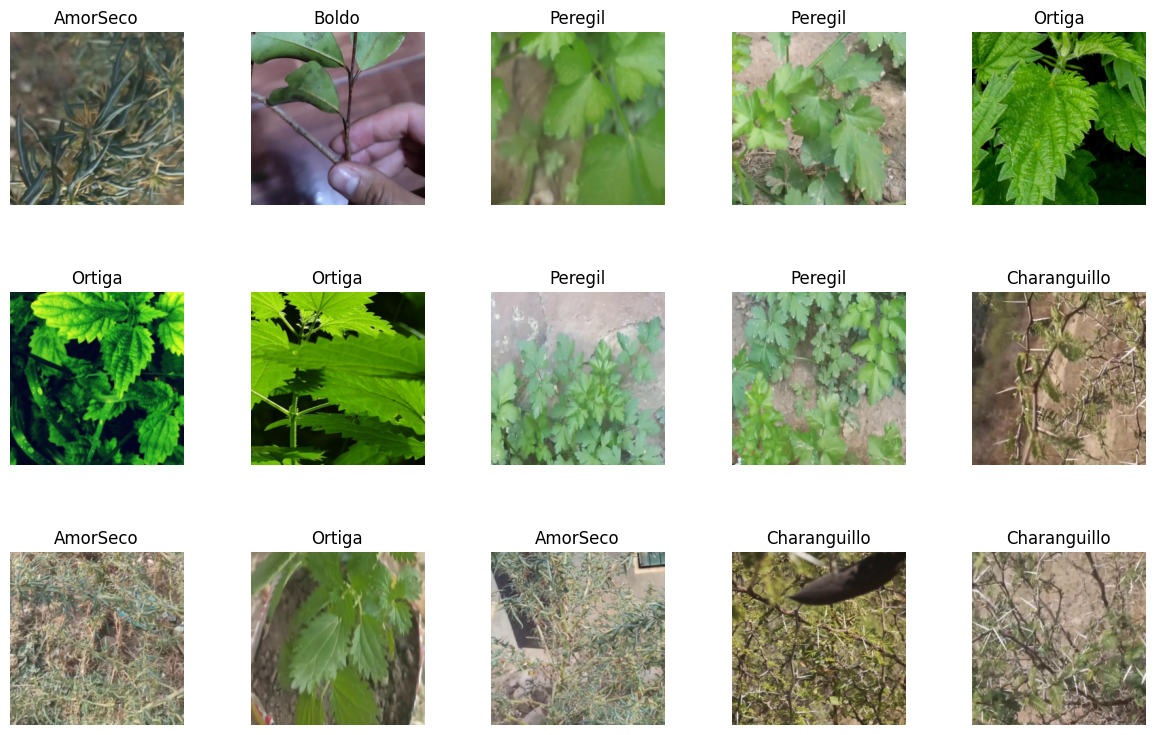

In [4]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Función para deshacer la transformación y convertir de tensor a imagen
def imshow(img):
    # Convirtiendo de tensor a numpy y cambiar el orden de los canales de (C, H, W) a (H, W, C)
    img = img.numpy().transpose((1, 2, 0))
    # Normalizando los valores de la imagen al rango [0, 1]
    img = np.clip(img, 0, 1)
    plt.imshow(img)

# Visualización de imágenes
r, c = 3, 5
plt.figure(figsize=(c * 3, r * 3))
for row in range(r):
    for col in range(c):
        index = c * row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset) - 1)
        img, label = trainset[ix]
        imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


* Verificamos que la distribución de las clases sea uniforme.

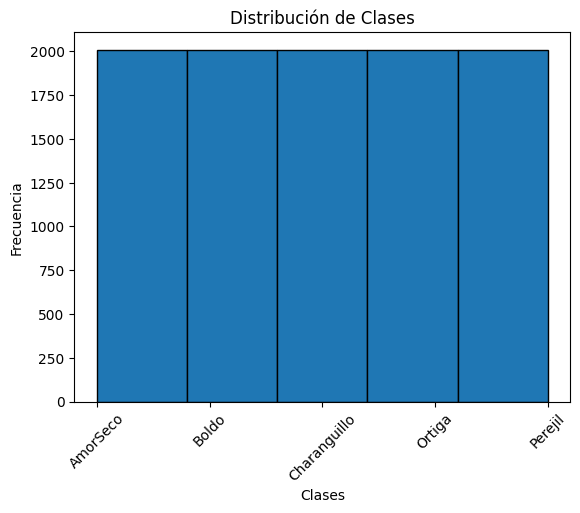

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Obteniendo las etiquetas correspondientes a los índices de entrenamiento
train_labels = [label for _, label in dataset.samples]
train_labels = np.array(train_labels)

# Nombres de las clases
class_names = list(dataset.class_to_idx.keys())

# Distribución de clases - Mostrar histograma de las primeras 30,000 imágenes (o menos si hay menos en el set)
plt.hist(train_labels[:30000], bins=len(class_names), edgecolor='black')
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
plt.xlabel('Clases')
plt.ylabel('Frecuencia')
plt.title('Distribución de Clases')
plt.show()


Definimos el diccionario para los dataloaders.

In [9]:
from torch.utils.data import DataLoader
# Creandoel diccionario de DataLoaders para entrenamiento y prueba
dataloader = {
    'train': DataLoader(trainset, batch_size=16, shuffle=True),
    'test': DataLoader(testset, batch_size=16, shuffle=False)
}

## El Modelo Preentrenado (RegNet-X-400F)
* Cargamos el modelo y observamos las capas que lo componen.

In [10]:
import torchvision.models as models

# Cargando el modelo RegNet preentrenado
regnet = models.regnet_x_400mf(pretrained=True)

# Mostrando la arquitectura del modelo
print(regnet)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
            

c:\Users\Jhamil\Desktop\IA2\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jhamil\Desktop\IA2\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_X_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


* Definimos una clase para el modelo preentrenado que nos permita modificar la última capa para adaptarla a nuestro problema. Tambien nos da la opcion de elegir si se desea congelar las capas del modelo preentrenado.

In [2]:
import torch
import torchvision

class ModelCustom(torch.nn.Module):
    def __init__(self, n_outputs=5, pretrained=False, freeze=False):
        super().__init__()
        # Descargando el modelo RegNet
        regnet = torchvision.models.regnet_x_400mf(pretrained=pretrained)
        # Extrayendo la parte convolucional del modelo
        self.regnet = torch.nn.Sequential(*list(regnet.children())[:-1])
        
        # Obteniendo el número de características de salida de la última capa convolucional
        num_features = regnet.fc.in_features
        
        if freeze:
            for param in self.regnet.parameters():
                param.requires_grad = False
        
        # Añadiendo una nueva capa lineal para la clasificación
        self.fc = torch.nn.Linear(num_features, n_outputs)

    def forward(self, x):
        x = self.regnet(x)
        x = x.view(x.shape[0], -1)  # Aplana el tensor
        x = self.fc(x)
        return x

    def unfreeze(self):
        for param in self.regnet.parameters():
            param.requires_grad = True


Verificamos que el modelo esta funcionando correctamente.

In [13]:
model_custom = ModelCustom()
outputs = model_custom(torch.randn(64, 3, 256, 256))
outputs.shape

c:\Users\Jhamil\Desktop\IA2\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([64, 5])

Definimos la funcion para el entrenamiento

In [14]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-3):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")


## Entrenamiento del modelo'
Inicialmente se entrena el modelo congelando las capas del modelo preentrenado.

In [15]:
model_c = ModelCustom(pretrained=True, freeze=True)
fit(model_c, dataloader)

val_loss 0.04447 val_acc 0.99603: 100%|██████████| 126/126 [00:15<00:00,  7.90it/s]


Epoch 1/5 loss 0.26306 val_loss 0.04447 acc 0.94785 val_acc 0.99603


val_loss 0.01959 val_acc 0.99802: 100%|██████████| 126/126 [00:16<00:00,  7.86it/s]


Epoch 2/5 loss 0.07150 val_loss 0.01959 acc 0.98695 val_acc 0.99802


val_loss 0.02000 val_acc 0.99554: 100%|██████████| 126/126 [00:16<00:00,  7.81it/s]


Epoch 3/5 loss 0.04613 val_loss 0.02000 acc 0.99056 val_acc 0.99554


val_loss 0.00816 val_acc 0.99901: 100%|██████████| 126/126 [00:16<00:00,  7.78it/s]


Epoch 4/5 loss 0.03611 val_loss 0.00816 acc 0.99081 val_acc 0.99901


val_loss 0.00900 val_acc 0.99802: 100%|██████████| 126/126 [00:16<00:00,  7.85it/s]

Epoch 5/5 loss 0.03201 val_loss 0.00900 acc 0.99230 val_acc 0.99802


Guardamos el modelo para poder cargarlo posteriormente.

In [16]:
# Ruta donde se guardará el modelo
path = r"C:\Users\Jhamil\Desktop\Modelos\model_transferLearning.pth"

# Guardar el estado del modelo
torch.save(model_c.state_dict(), path)

### Fine-Tuning
Se entrena el modelo sin congelar las capas del modelo preentrenado, para que se ajusten los pesos de todas las capas.

In [17]:
model_c = ModelCustom(pretrained=True, freeze=False)
fit(model_c, dataloader)

val_loss 0.01579 val_acc 0.99425: 100%|██████████| 126/126 [00:14<00:00,  8.86it/s]


Epoch 1/5 loss 0.10984 val_loss 0.01579 acc 0.96492 val_acc 0.99425


val_loss 0.06342 val_acc 0.98165: 100%|██████████| 126/126 [00:15<00:00,  8.27it/s]


Epoch 2/5 loss 0.05358 val_loss 0.06342 acc 0.98360 val_acc 0.98165


val_loss 0.01841 val_acc 0.99454: 100%|██████████| 126/126 [00:15<00:00,  8.10it/s]


Epoch 3/5 loss 0.02713 val_loss 0.01841 acc 0.99105 val_acc 0.99454


val_loss 0.00039 val_acc 1.00000: 100%|██████████| 126/126 [00:14<00:00,  8.42it/s]


Epoch 4/5 loss 0.01787 val_loss 0.00039 acc 0.99441 val_acc 1.00000


val_loss 0.00695 val_acc 0.99752: 100%|██████████| 126/126 [00:14<00:00,  8.54it/s]

Epoch 5/5 loss 0.02065 val_loss 0.00695 acc 0.99296 val_acc 0.99752


Guardamos el modelo para poder cargarlo posteriormente.

In [ ]:
# Ruta donde se guardará el modelo
path = r"C:\Users\Jhamil\Desktop\Modelos\model_fine_tuning.pth"

# Guardar el estado del modelo
torch.save(model_c.state_dict(), path)

## Evaluación del modelo
* Cargamos el primer modelo entrenado con las capas congeladas y lo ponemos en modo evaluacion.

In [4]:
# Define el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Crea una nueva instancia del modelo
model = ModelCustom(pretrained=True, freeze=True) # Asegúrate de usar los mismos parámetros

# Ruta del archivo donde se guardó el modelo
path = r"C:\Users\Jhamil\Desktop\Modelos\model_transferLearning.pth"

# Cargar el estado del modelo
model.load_state_dict(torch.load(path))
model.to(device)

# Configurar el modelo en modo evaluación
model.eval()

c:\Users\Jhamil\Desktop\IA2\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jhamil\Desktop\IA2\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_X_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Jhamil\AppData\Local\Temp\ipykernel_8784\2498544936.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytor

ModelCustom(
  (regnet): Sequential(
    (0): SimpleStemIN(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (block1): AnyStage(
        (block1-0): ResBottleneckBlock(
          (proj): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (f): BottleneckTransform(
            (a): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (b): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2,

Realizamos una prueba de prediccion con una variedad de imagenes, que no estaban el dataset, para evaluar al modelo.

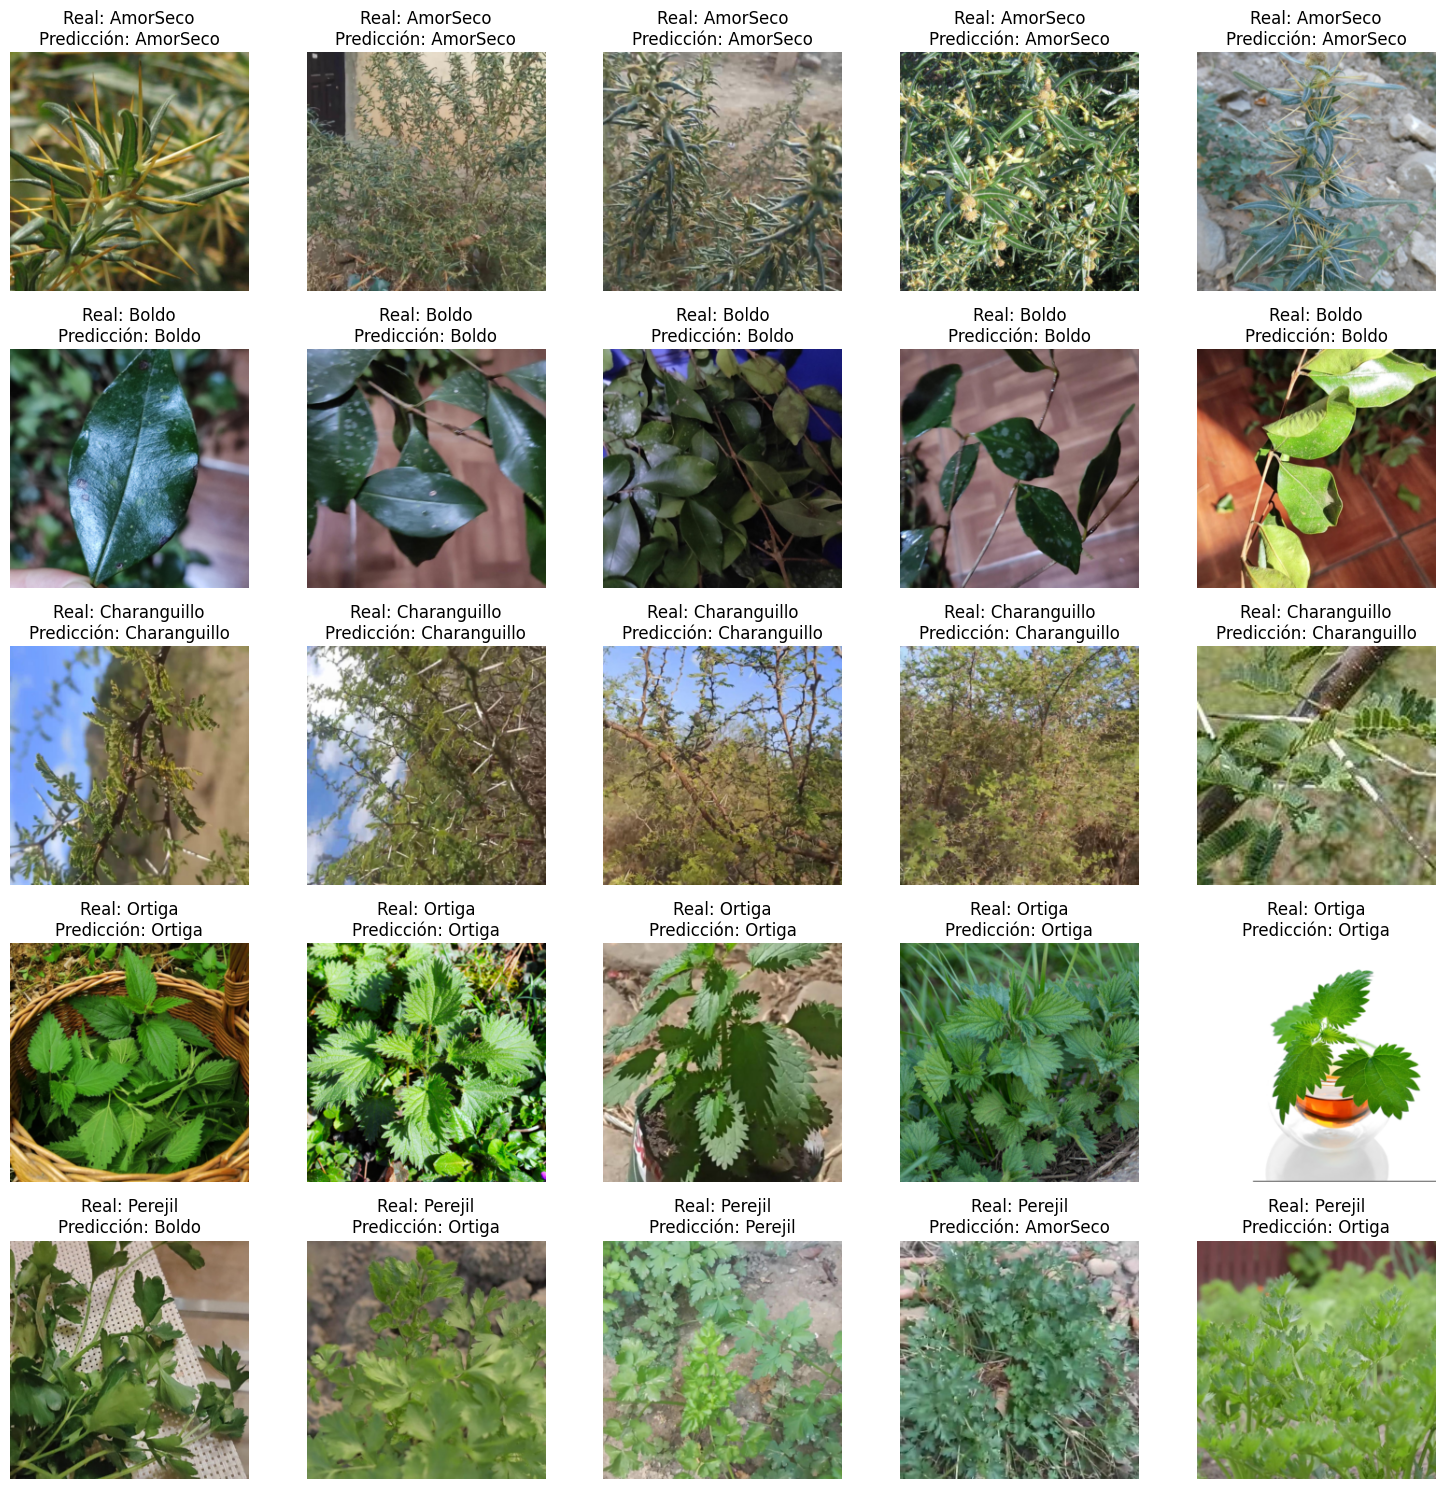

In [5]:
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

# Definir las transformaciones (deben ser las mismas que se usaron para el entrenamiento)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Ruta a la carpeta que contiene las imágenes para prueba
test_folder = r"C:\Users\Jhamil\Desktop\ImagenesPrueba"

# Cargar las imágenes
test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Función para mostrar una cuadrícula de imágenes con sus etiquetas reales y predicciones
def show_images_grid(images, labels, predictions, class_names, num_columns=5):
    num_images = len(images)
    num_rows = (num_images + num_columns - 1) // num_columns  # Calcular el número de filas
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 3))
    axes = axes.flatten()
    
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0))  # Convertir tensor a imagen
        ax.set_title(f'Real: {class_names[labels[i]]}\nPredicción: {class_names[predictions[i]]}')
        ax.axis('off')
    
    for j in range(num_images, len(axes)):  # Ocultar ejes adicionales
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Obtener las clases
class_names = test_dataset.classes

# Realizar inferencias y almacenar resultados
images_list = []
labels_list = []
predictions_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Mover imágenes y etiquetas al dispositivo
        # Hacer predicción
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Almacenar imágenes, etiquetas reales y predicciones
        images_list.append(images[0].cpu())  # Obtener la imagen de tamaño de lote 1
        labels_list.append(labels[0].item())  # Obtener la etiqueta real
        predictions_list.append(preds[0].item())  # Obtener la predicción

# Mostrar las imágenes en una cuadrícula de 5 columnas
show_images_grid(images_list, labels_list, predictions_list, class_names, num_columns=5)


* Cargamos el segundo modelo entrenado usando Fine-Tuning y lo ponemos en modo evaluacion.

In [6]:
# Define el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Crea una nueva instancia del modelo
model = ModelCustom(pretrained=True, freeze=False) # Asegúrate de usar los mismos parámetros

# Ruta del archivo donde se guardó el modelo
path = r"C:\Users\Jhamil\Desktop\Modelos\model_fine_tuning.pth"

# Cargar el estado del modelo
model.load_state_dict(torch.load(path))
model.to(device)

# Configurar el modelo en modo evaluación
model.eval()

c:\Users\Jhamil\Desktop\IA2\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jhamil\Desktop\IA2\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_X_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Jhamil\AppData\Local\Temp\ipykernel_8784\2882494646.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytor

ModelCustom(
  (regnet): Sequential(
    (0): SimpleStemIN(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (block1): AnyStage(
        (block1-0): ResBottleneckBlock(
          (proj): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (f): BottleneckTransform(
            (a): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (b): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2,

Realizamos una prueba de prediccion con una variedad de imagenes, que no estaban el dataset, para evaluar al modelo.

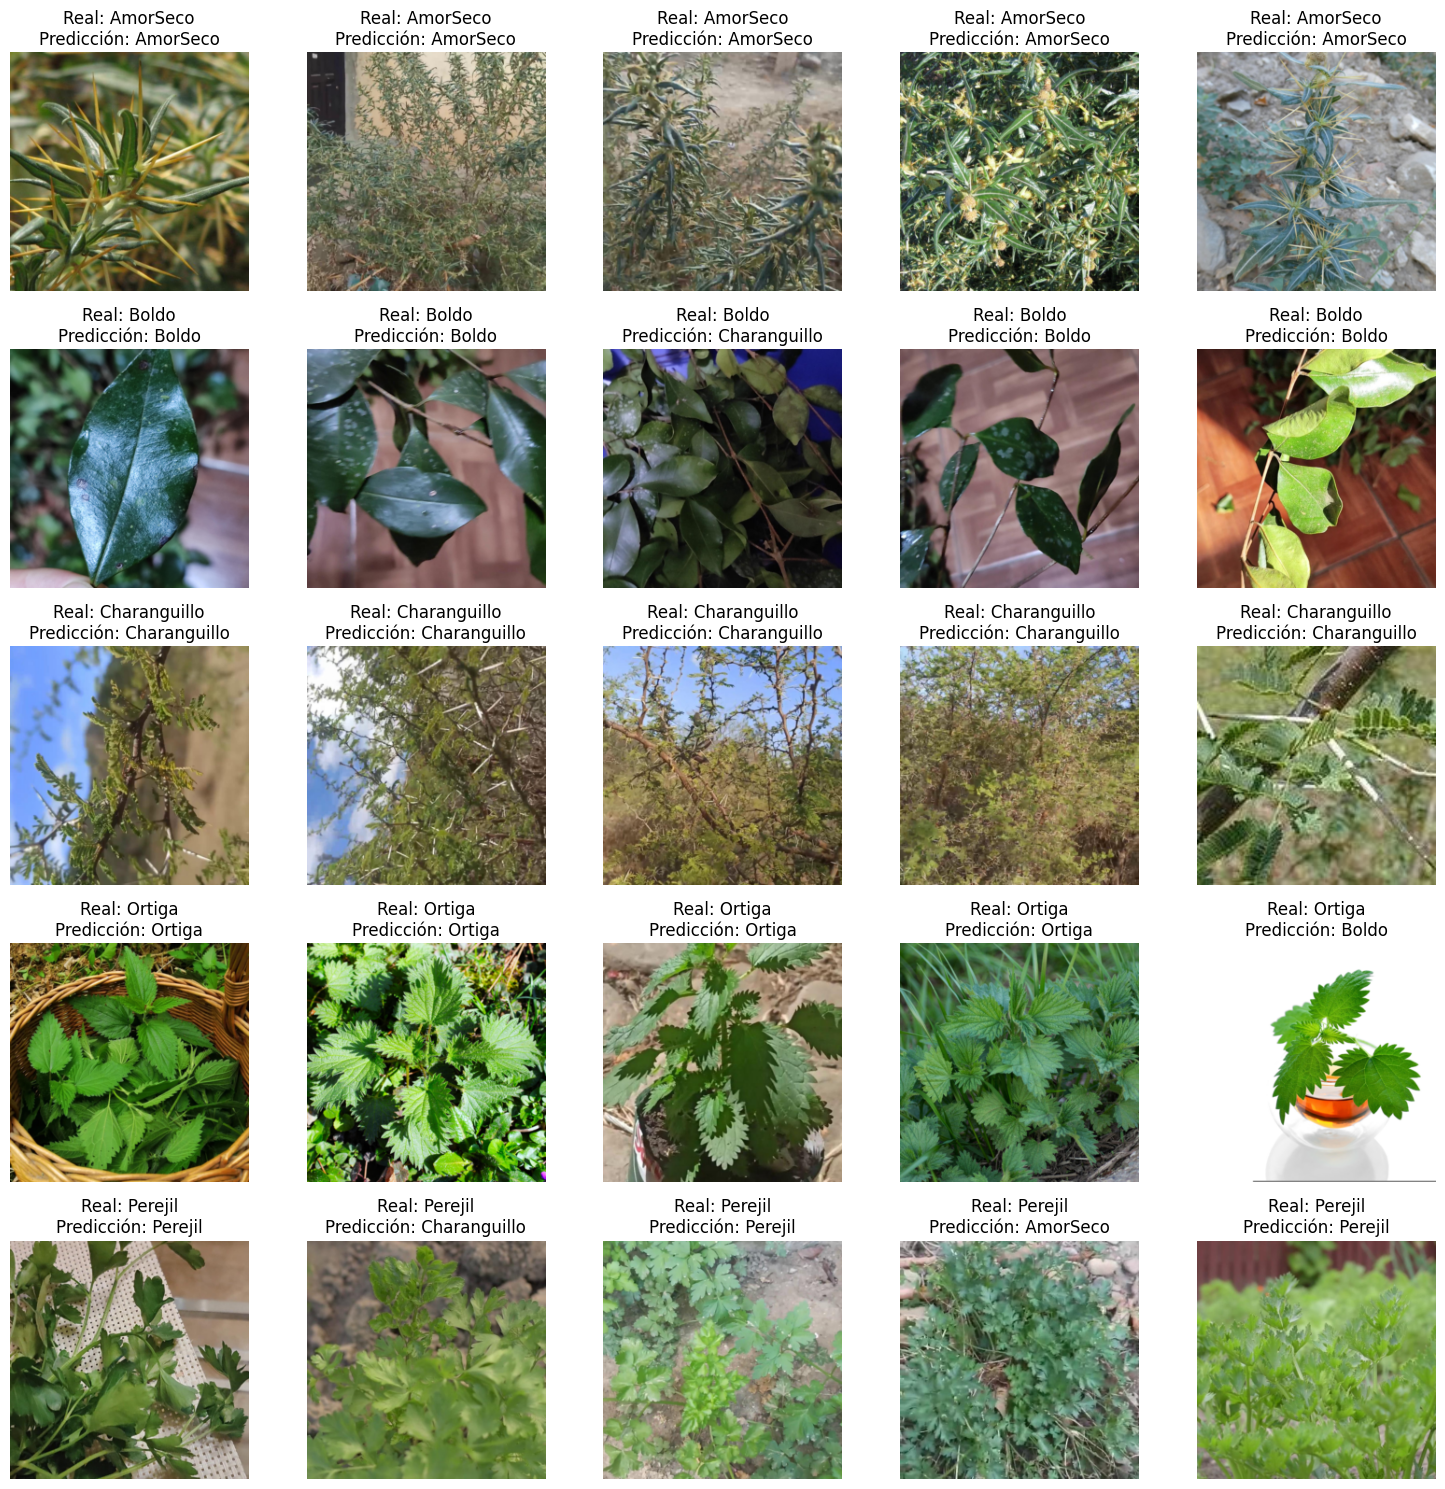

In [7]:
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

# Definir las transformaciones (deben ser las mismas que se usaron para el entrenamiento)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Ruta a la carpeta que contiene las imágenes para prueba
test_folder = r"C:\Users\Jhamil\Desktop\ImagenesPrueba"

# Cargar las imágenes
test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Función para mostrar una cuadrícula de imágenes con sus etiquetas reales y predicciones
def show_images_grid(images, labels, predictions, class_names, num_columns=5):
    num_images = len(images)
    num_rows = (num_images + num_columns - 1) // num_columns  # Calcular el número de filas
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 3))
    axes = axes.flatten()
    
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0))  # Convertir tensor a imagen
        ax.set_title(f'Real: {class_names[labels[i]]}\nPredicción: {class_names[predictions[i]]}')
        ax.axis('off')
    
    for j in range(num_images, len(axes)):  # Ocultar ejes adicionales
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Obtener las clases
class_names = test_dataset.classes

# Realizar inferencias y almacenar resultados
images_list = []
labels_list = []
predictions_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Mover imágenes y etiquetas al dispositivo
        # Hacer predicción
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Almacenar imágenes, etiquetas reales y predicciones
        images_list.append(images[0].cpu())  # Obtener la imagen de tamaño de lote 1
        labels_list.append(labels[0].item())  # Obtener la etiqueta real
        predictions_list.append(preds[0].item())  # Obtener la predicción

# Mostrar las imágenes en una cuadrícula de 5 columnas
show_images_grid(images_list, labels_list, predictions_list, class_names, num_columns=5)
